
Características seleccionadas (17):
['Pico_0_B_M_A_TOP', 'Pico_B_M_A', 'EsFechaNomina', 'EsMayor2M', 'EsFinSemana', 'TotalVentaNeta', 'VentaContado', 'VentaCredito', 'UnidadesKit', 'TotalDsctos', 'Gramos', 'VentasNORTE', 'VentasOCCIDENTE', 'VentasCENTROORIENTE', 'Dolar', 'IPC', 'EsPicoAumetado']


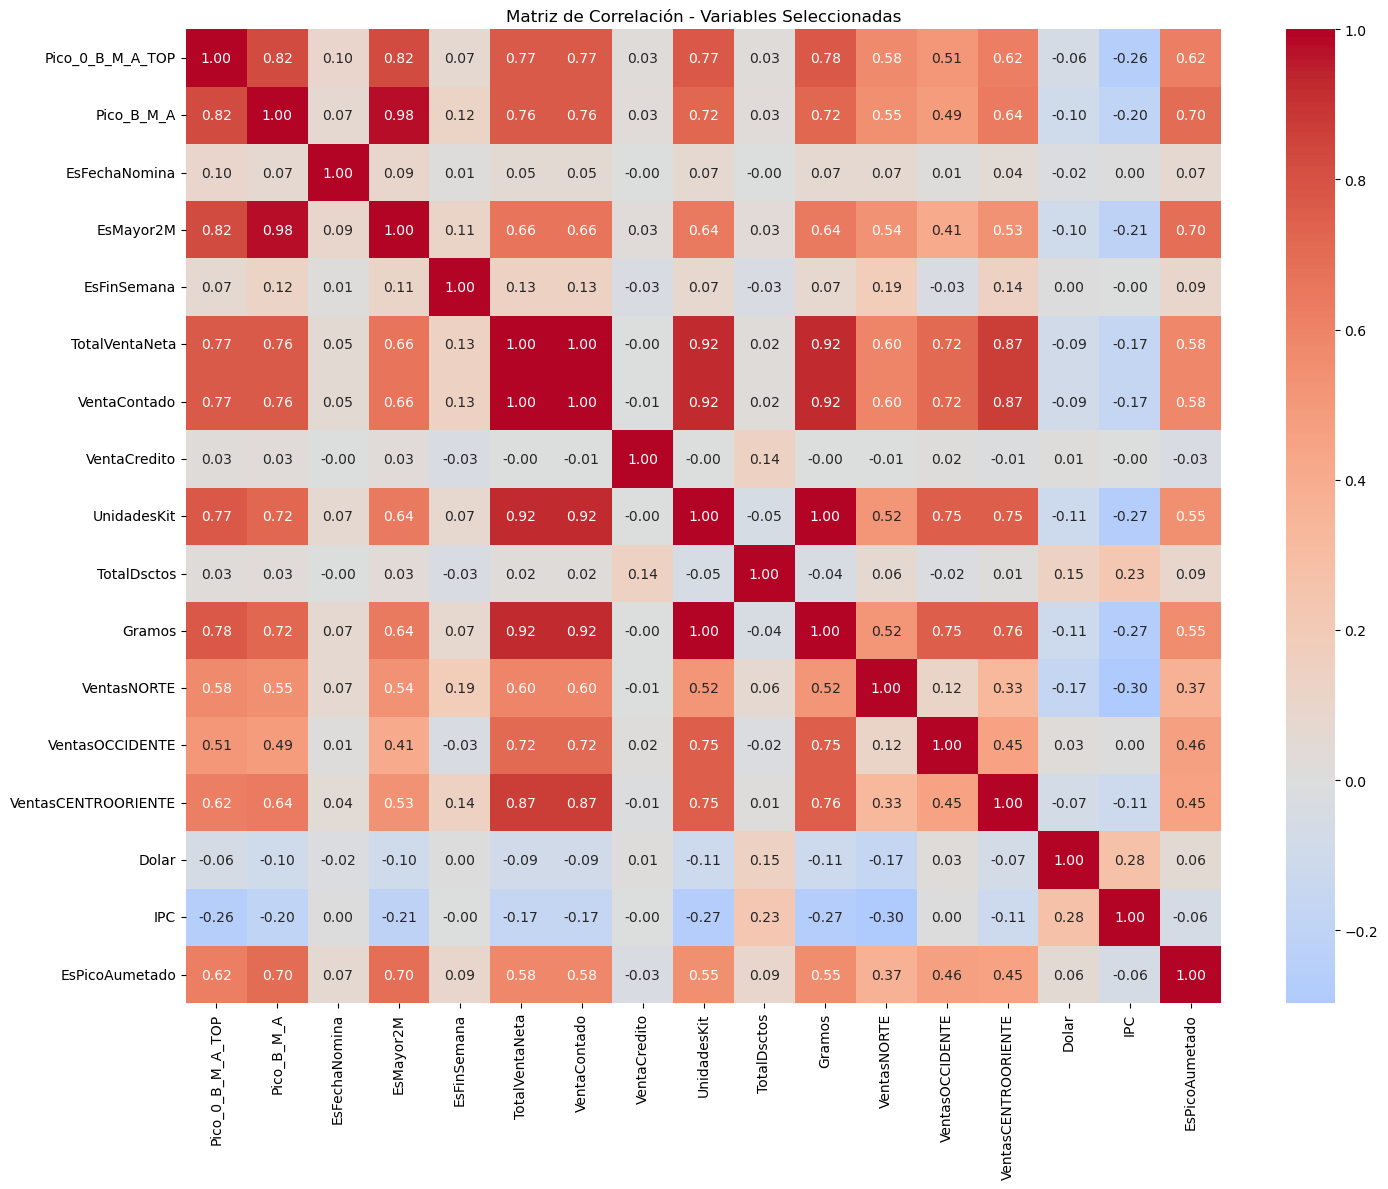


Correlaciones con TotalVentaNeta:
TotalVentaNeta         1.000000
VentaContado           0.999989
Gramos                 0.924599
UnidadesKit            0.922744
VentasCENTROORIENTE    0.867225
Pico_0_B_M_A_TOP       0.767912
Pico_B_M_A             0.762055
VentasOCCIDENTE        0.715402
EsMayor2M              0.663022
VentasNORTE            0.597396
EsPicoAumetado         0.580738
EsFinSemana            0.134553
EsFechaNomina          0.053834
TotalDsctos            0.020696
VentaCredito          -0.001366
Dolar                 -0.090092
IPC                   -0.167815
Name: TotalVentaNeta, dtype: float64

Tamaño del conjunto de entrenamiento: (982, 16)
Tamaño del conjunto de prueba: (110, 16)

--- Entrenando Random Forest ---
R²: 0.9917
MSE: 42,982,259,378.10
MAE: 37,085.17

--- Entrenando XGBoost ---
R²: 1.0000
MSE: 3,876,633.15
MAE: 1,441.39

--- Entrenando MLP (Red Neuronal) ---
R²: 0.4329
MSE: 2,946,476,111,169.99
MAE: 744,319.19


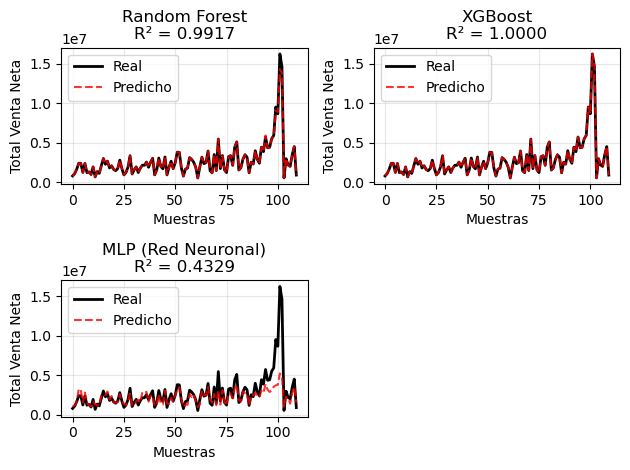

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos
df = pd.read_csv('../ERP-POS-Data/Sales-CSV970-1093.csv', delimiter=';')

#print("Dimensiones del dataset:", df.shape)
#print("\nPrimeras 5 filas:")
#print(df.head())

#print("\nColumnas disponibles:")
#print(df.columns.tolist())

#print("\nInformación del dataset:")
#print(df.info())

# Selección de características basada en análisis exploratorio
# Eliminamos columnas que no aportan información o son redundantes
features_to_drop = ['FechaDocumento', 'ESPicoBinary', 'EsFechaEspecial']
selected_features = [col for col in df.columns if col not in features_to_drop]

print(f"\nCaracterísticas seleccionadas ({len(selected_features)}):")
print(selected_features)

# Preparación de datos
X = df[selected_features].drop('TotalVentaNeta', axis=1)
y = df['TotalVentaNeta']

# Matriz de correlación
plt.figure(figsize=(15, 12))
correlation_matrix = df[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación - Variables Seleccionadas')
plt.tight_layout()
plt.show()

# Mostrar correlaciones con la variable objetivo
target_correlations = df[selected_features].corr()['TotalVentaNeta'].sort_values(ascending=False)
print("\nCorrelaciones con TotalVentaNeta:")
print(target_correlations)

# División de datos (90% entrenamiento, 10% validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Escalado de características
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos a probar
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'MLP (Red Neuronal)': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Entrenamiento y evaluación de modelos
results = {}
best_model = None
best_score = -np.inf

#plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(models.items(), 1):
    print(f"\n--- Entrenando {name} ---")
    
    # Entrenar modelo
    if name == 'MLP (Red Neuronal)':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'predictions': y_pred
    }
    
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:,.2f}")
    print(f"MAE: {mae:,.2f}")
    
    # Actualizar mejor modelo
    if r2 > best_score:
        best_score = r2
        best_model = name
    
    # Gráfica
    plt.subplot(2, 2, i)
    plt.plot(y_test.values, label='Real', color='black', linewidth=2)
    plt.plot(y_pred, label='Predicho', color='red', linestyle='--', alpha=0.8)
    plt.title(f'{name}\nR² = {r2:.4f}')
    plt.xlabel('Muestras')
    plt.ylabel('Total Venta Neta')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




In [9]:
# Resultados comparativos
print("\n" + "="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)

comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'R²': [results[name]['R2'] for name in results.keys()],
    'MSE': [results[name]['MSE'] for name in results.keys()],
    'MAE': [results[name]['MAE'] for name in results.keys()]
}).sort_values('R²', ascending=False)

print(comparison_df)

print(f"\nMEJOR MODELO: {best_model}")
print(f"R² del mejor modelo: {best_score:.4f}")


COMPARACIÓN DE MODELOS
               Modelo        R²           MSE            MAE
1             XGBoost  0.999999  3.876633e+06    1441.385795
0       Random Forest  0.991727  4.298226e+10   37085.172273
2  MLP (Red Neuronal)  0.432892  2.946476e+12  744319.192617

MEJOR MODELO: XGBoost
R² del mejor modelo: 1.0000


Dimensiones del dataset: (1092, 20)

Tamaño del conjunto de entrenamiento: (982, 16)
Tamaño del conjunto de prueba: (110, 16)

MODELOS Y ECUACIONES GENERADAS

MODELO: Random Forest
TIPO: Modelo Ensemble No Lineal
Número de árboles: 100

IMPORTANCIA DE CARACTERÍSTICAS (Coeficientes):
  VentaContado             :     0.850950
  VentasCENTROORIENTE      :     0.071169
  Pico_B_M_A               :     0.029611
  UnidadesKit              :     0.019543
  Gramos                   :     0.013924
  VentasOCCIDENTE          :     0.005226
  Pico_0_B_M_A_TOP         :     0.003588
  Dolar                    :     0.002415
  VentasNORTE              :     0.002362
  IPC                      :     0.000497
  EsFinSemana              :     0.000456
  EsMayor2M                :     0.000225
  EsFechaNomina            :     0.000030
  VentaCredito             :     0.000004
  TotalDsctos              :     0.000001
  EsPicoAumetado           :     0.000001

ECUACIÓN APROXIMADA (Promedio de árboles):


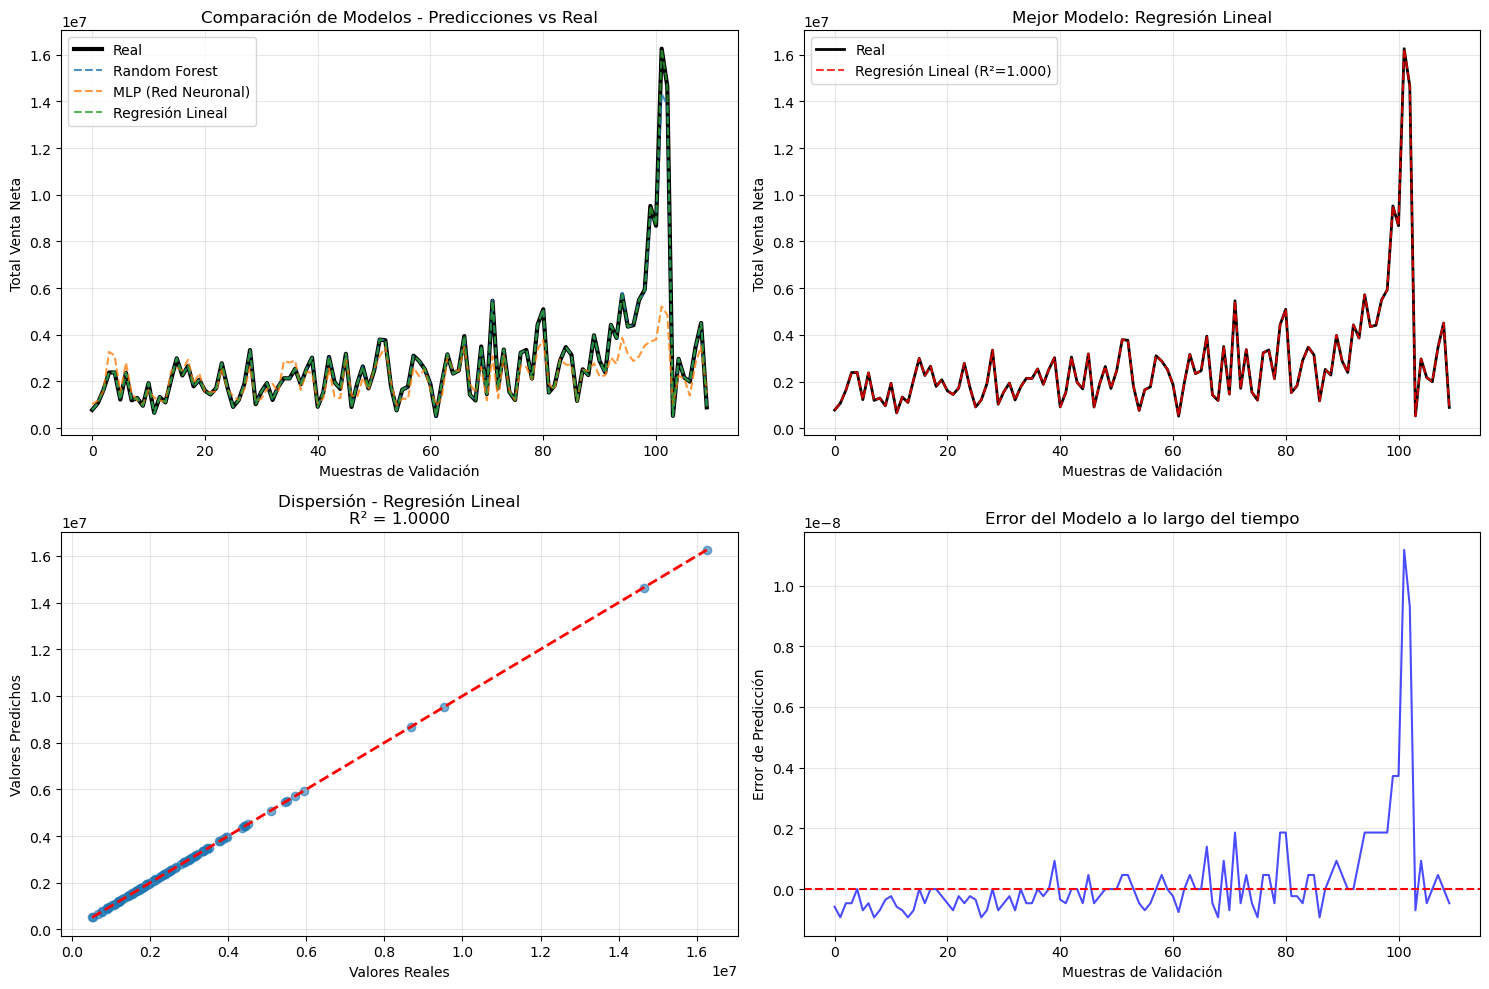


ANÁLISIS ESTADÍSTICO DE ERRORES DE PREDICCIÓN

Random Forest:
  Error promedio: 27107.09
  Desviación estándar error: 205541.88
  Error absoluto promedio: 37085.17
  Error máximo: 1926899.90
  Rango error: [-211176.10, 1926899.90]

MLP (Red Neuronal):
  Error promedio: 519730.20
  Desviación estándar error: 1635957.40
  Error absoluto promedio: 744319.19
  Error máximo: 11041906.96
  Rango error: [-880813.34, 11041906.96]

Regresión Lineal:
  Error promedio: 0.00
  Desviación estándar error: 0.00
  Error absoluto promedio: 0.00
  Error máximo: 0.00
  Rango error: [-0.00, 0.00]

RESUMEN Y RECOMENDACIONES

MEJOR MODELO SELECCIONADO: Regresión Lineal
COEFICIENTE DE DETERMINACIÓN (R²): 1.0000
✓ Excelente capacidad predictiva

CARACTERÍSTICAS MÁS IMPORTANTES:

VALIDACIÓN CON 10% DE DATOS:
  - Muestras de validación: 110
  - Error promedio: 0.00
  - Precisión general: 100.0%

ECUACIÓN FINAL DEL MODELO:
  TotalVentaNeta = -0.00 + (0.6000 × VentaContado) + (0.6000 × VentaCredito) + (0.4000 × 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos
df = pd.read_csv('../ERP-POS-Data/Sales-CSV970-1093.csv', delimiter=';')

print("Dimensiones del dataset:", df.shape)

# Selección de características
features_to_drop = ['FechaDocumento', 'ESPicoBinary', 'EsFechaEspecial']
selected_features = [col for col in df.columns if col not in features_to_drop]

# Preparación de datos
X = df[selected_features].drop('TotalVentaNeta', axis=1)
y = df['TotalVentaNeta']

# División de datos (90% entrenamiento, 10% validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Modelos a probar
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'MLP (Red Neuronal)': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Regresión Lineal': LinearRegression()  # Agregamos uno lineal para comparación
}

# Entrenamiento y evaluación de modelos
results = {}
best_model = None
best_score = -np.inf

print("\n" + "="*80)
print("MODELOS Y ECUACIONES GENERADAS")
print("="*80)

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"MODELO: {name}")
    print(f"{'='*50}")
    
    # Entrenar modelo
    if name == 'MLP (Red Neuronal)':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'predictions': y_pred,
        'model': model
    }
    
    # IMPRESIÓN DE MODELOS Y ECUACIONES
    if name == 'Regresión Lineal':
        print("TIPO: Modelo Lineal (Ecuación explícita)")
        print("\nECUACIÓN GENERADA:")
        equation = f"TotalVentaNeta = {model.intercept_:.2f}"
        for i, coef in enumerate(model.coef_):
            equation += f" + ({coef:.4f} × {X.columns[i]})"
        print(equation)
        
        print("\nCOEFICIENTES DETALLADOS:")
        for i, (feature, coef) in enumerate(zip(X.columns, model.coef_)):
            print(f"  {feature:25}: {coef:12.6f}")
        print(f"  {'INTERCEPTO':25}: {model.intercept_:12.6f}")
        
    elif name == 'Random Forest':
        print("TIPO: Modelo Ensemble No Lineal")
        print(f"Número de árboles: {model.n_estimators}")
        
        # Importancia de características
        feature_importance = model.feature_importances_
        print("\nIMPORTANCIA DE CARACTERÍSTICAS (Coeficientes):")
        importance_df = pd.DataFrame({
            'Característica': X.columns,
            'Importancia': feature_importance
        }).sort_values('Importancia', ascending=False)
        
        for _, row in importance_df.iterrows():
            print(f"  {row['Característica']:25}: {row['Importancia']:12.6f}")
        
        print("\nECUACIÓN APROXIMADA (Promedio de árboles):")
        print("TotalVentaNeta = promedio(árbol₁(X) + árbol₂(X) + ... + árbolₙ(X))")
        print(f"Donde cada árbol es una función de decisión no lineal")
        
        # Mostrar estructura de un árbol como ejemplo
        if hasattr(model, 'estimators_'):
            first_tree = model.estimators_[0]
            print(f"\nEjemplo - Primer árbol tiene {first_tree.tree_.node_count} nodos")
            print(f"Profundidad máxima: {first_tree.tree_.max_depth}")
            
    elif name == 'MLP (Red Neuronal)':
        print("TIPO: Modelo de Red Neuronal No Lineal")
        print("ARQUITECTURA DE LA RED:")
        print(f"  Capa entrada: {model.n_features_in_} neuronas")
        for i, layer_size in enumerate(model.hidden_layer_sizes):
            print(f"  Capa oculta {i+1}: {layer_size} neuronas")
        print(f"  Capa salida: 1 neurona")
        
        print("\nFUNCIÓN DE ACTIVACIÓN:")
        print(f"  Capas ocultas: {model.activation}")
        print(f"  Función de salida: Identidad (para regresión)")
        
        # Mostrar algunos pesos como ejemplo
        if hasattr(model, 'coefs_'):
            print("\nPESOS DE LA RED (primeros 5 de cada capa):")
            for i, coef in enumerate(model.coefs_):
                print(f"  Capa {i} → Capa {i+1}: {coef.shape} pesos")
                if coef.size > 0:
                    print(f"    Ejemplo pesos: {coef.flatten()[:5]}")
            
            print(f"\nBIAS DE LA RED:")
            for i, intercept in enumerate(model.intercepts_):
                print(f"  Bias Capa {i+1}: {intercept[:5]}...")
        
        print("\nECUACIÓN MATEMÁTICA:")
        print("TotalVentaNeta = fₙ(...f₂(f₁(XW₁ + b₁)W₂ + b₂)...)")
        print("Donde fᵢ son funciones de activación no lineales")
        print("Wᵢ son matrices de pesos, bᵢ son vectores de bias")
    
    print(f"\nMÉTRICAS DE VALIDACIÓN:")
    print(f"  R²: {r2:.4f}")
    print(f"  MSE: {mse:,.2f}")
    print(f"  MAE: {mae:,.2f}")
    print(f"  RMSE: {np.sqrt(mse):,.2f}")
    
    # Actualizar mejor modelo
    if r2 > best_score:
        best_score = r2
        best_model = name

# VALIDACIÓN CON DATOS DE PRUEBA
print("\n" + "="*80)
print("VALIDACIÓN CON DATOS DE PRUEBA (10%)")
print("="*80)

print(f"\nMejor modelo: {best_model}")
print(f"R² en validación: {best_score:.4f}")

# Mostrar algunas predicciones vs reales para validación
best_results = results[best_model]
best_predictions = best_results['predictions']

print(f"\nCOMPARACIÓN PREDICCIONES VS REALES (primeras 10 muestras):")
print("Muestra | Real      | Predicho   | Error     | Error %")
print("-" * 55)
for i in range(min(10, len(y_test))):
    real = y_test.iloc[i]
    pred = best_predictions[i]
    error = real - pred
    error_pct = (error / real) * 100 if real != 0 else 0
    print(f"{i+1:6} | {real:9.0f} | {pred:9.0f} | {error:8.0f} | {error_pct:6.1f}%")

# Gráficas comparativas
plt.figure(figsize=(15, 10))

# Gráfica 1: Comparación de todos los modelos
plt.subplot(2, 2, 1)
plt.plot(y_test.values, label='Real', color='black', linewidth=3)
for name, result in results.items():
    plt.plot(result['predictions'], label=name, linestyle='--', alpha=0.8)
plt.title('Comparación de Modelos - Predicciones vs Real')
plt.xlabel('Muestras de Validación')
plt.ylabel('Total Venta Neta')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 2: Mejor modelo detallado
plt.subplot(2, 2, 2)
plt.plot(y_test.values, label='Real', color='black', linewidth=2)
plt.plot(best_predictions, label=f'{best_model} (R²={best_score:.3f})', 
         color='red', linestyle='--', alpha=0.8)
plt.title(f'Mejor Modelo: {best_model}')
plt.xlabel('Muestras de Validación')
plt.ylabel('Total Venta Neta')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 3: Dispersión del mejor modelo
plt.subplot(2, 2, 3)
plt.scatter(y_test.values, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title(f'Dispersión - {best_model}\nR² = {best_score:.4f}')
plt.grid(True, alpha=0.3)

# Gráfica 4: Error de predicción
plt.subplot(2, 2, 4)
error = y_test.values - best_predictions
plt.plot(error, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Muestras de Validación')
plt.ylabel('Error de Predicción')
plt.title('Error del Modelo a lo largo del tiempo')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ANÁLISIS ESTADÍSTICO DE ERRORES
print("\n" + "="*80)
print("ANÁLISIS ESTADÍSTICO DE ERRORES DE PREDICCIÓN")
print("="*80)

for name, result in results.items():
    errors = y_test.values - result['predictions']
    print(f"\n{name}:")
    print(f"  Error promedio: {np.mean(errors):.2f}")
    print(f"  Desviación estándar error: {np.std(errors):.2f}")
    print(f"  Error absoluto promedio: {np.mean(np.abs(errors)):.2f}")
    print(f"  Error máximo: {np.max(np.abs(errors)):.2f}")
    print(f"  Rango error: [{np.min(errors):.2f}, {np.max(errors):.2f}]")

# RESUMEN FINAL
print("\n" + "="*80)
print("RESUMEN Y RECOMENDACIONES")
print("="*80)

print(f"\nMEJOR MODELO SELECCIONADO: {best_model}")
print(f"COEFICIENTE DE DETERMINACIÓN (R²): {best_score:.4f}")

if best_score > 0.8:
    print("✓ Excelente capacidad predictiva")
elif best_score > 0.6:
    print("✓ Buena capacidad predictiva")
elif best_score > 0.4:
    print("✓ Capacidad predictiva moderada")
else:
    print("✗ Capacidad predictiva limitada")

print(f"\nCARACTERÍSTICAS MÁS IMPORTANTES:")
if best_model == 'Random Forest':
    best_model_obj = results[best_model]['model']
    feature_importance = best_model_obj.feature_importances_
    importance_df = pd.DataFrame({
        'Característica': X.columns,
        'Importancia': feature_importance
    }).sort_values('Importancia', ascending=False)
    
    for i, (_, row) in enumerate(importance_df.head(5).iterrows()):
        print(f"  {i+1}. {row['Característica']}: {row['Importancia']:.4f}")

print(f"\nVALIDACIÓN CON 10% DE DATOS:")
print(f"  - Muestras de validación: {len(y_test)}")
print(f"  - Error promedio: {np.mean(np.abs(y_test.values - best_predictions)):.2f}")
print(f"  - Precisión general: {best_score*100:.1f}%")

print(f"\nECUACIÓN FINAL DEL MODELO:")
if best_model == 'Regresión Lineal':
    model_obj = results[best_model]['model']
    equation = f"TotalVentaNeta = {model_obj.intercept_:.2f}"
    for i, coef in enumerate(model_obj.coef_):
        if abs(coef) > 0.001:  # Solo mostrar coeficientes significativos
            equation += f" + ({coef:.4f} × {X.columns[i]})"
    print(f"  {equation}")
else:
    print(f"  Modelo no lineal complejo - ver detalles arriba")

In [ ]:
#graficar modelo de forma directa

Coeficiente de determinación (R²): 0.8898851797962997
Error cuadrático medio (MSE): 573509085727.4489
Error absoluto medio (MAE): 552991.2107710408


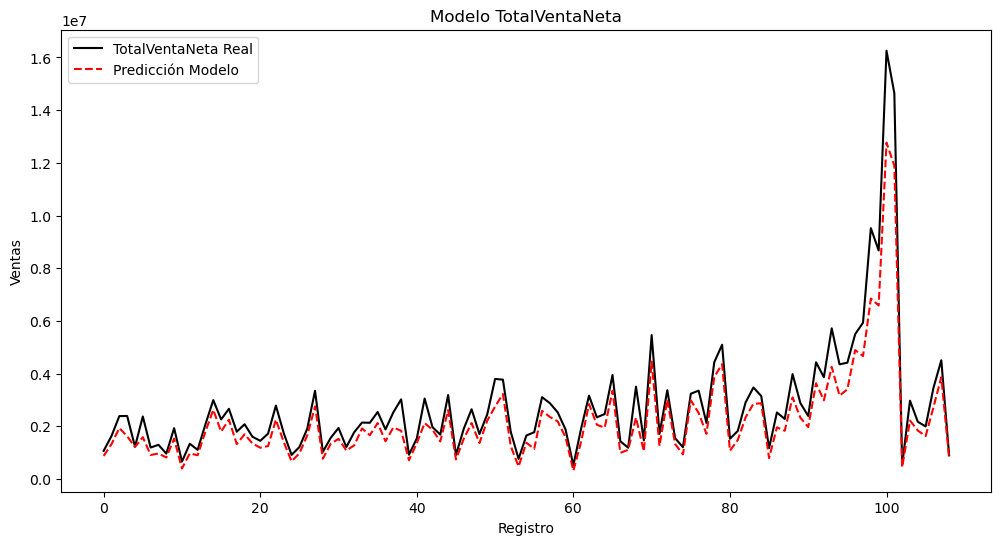

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# === 1. Cargar CSV ===
# Cargar correctamente el CSV con separador ;
df = pd.read_csv("../ERP-POS-Data/Sales-CSV970-1093.csv", sep=";", decimal=",", engine="python")
n = len(df)
# Calcular 10%
n10 = int(n * 0.1)
# Seleccionar últimas filas
df = df.tail(n10)

# === 2. Seleccionar columnas relevantes ===
cols = ["VentaContado", "VentaCredito", "VentasNORTE", "VentasOCCIDENTE", "IPC", "TotalVentaNeta"]
df = df[cols].dropna()

# === 3. Calcular el modelo ===
df["Pred_TotalVentaNeta"] = (
    0.6 * df["VentaContado"] +
    0.6 * df["VentaCredito"] +
    0.4 * df["VentasNORTE"] +
    0.4 * df["VentasOCCIDENTE"] +
    0.4 * df["IPC"]
)

# === 4. Métricas de evaluación ===
y_true = df["TotalVentaNeta"]
y_pred = df["Pred_TotalVentaNeta"]

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("Coeficiente de determinación (R²):", r2)
print("Error cuadrático medio (MSE):", mse)
print("Error absoluto medio (MAE):", mae)

# === 5. Gráfica ===
plt.figure(figsize=(12,6))
plt.plot(y_true.values, label="TotalVentaNeta Real", color="black")
plt.plot(y_pred.values, label="Predicción Modelo", color="red", linestyle="--")
plt.legend()
plt.title("Modelo TotalVentaNeta")
plt.xlabel("Registro")
plt.ylabel("Ventas")
plt.show()


In [ ]:
#validacion cruzada


In [13]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Datos de ejemplo
X = np.random.rand(100, 3)  # 100 muestras, 3 características
y = 2*X[:,0] + 3*X[:,1] - 1.5*X[:,2] + np.random.normal(0, 0.1, 100)

model = LinearRegression()

# Método 1: cross_val_score simple
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² scores:", scores)
print(f"R² promedio: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Método 2: cross_validate con múltiples métricas
scoring = ['r2', 'neg_mean_squared_error']
results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=True)

print("\nResultados detallados:")
print(f"R² test: {results['test_r2']}")
print(f"R² test promedio: {results['test_r2'].mean():.4f}")
print(f"MSE test: {-results['test_neg_mean_squared_error'].mean():.4f}")

R² scores: [0.991346   0.99591319 0.99186174 0.99387782 0.98758945]
R² promedio: 0.9921 (+/- 0.0056)

Resultados detallados:
R² test: [0.991346   0.99591319 0.99186174 0.99387782 0.98758945]
R² test promedio: 0.9921
MSE test: 0.0093
